In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#reading in all words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
#Building the vocabulary of characters and mappings to integrers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)


{0: '.', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


In [7]:
#building the dataset
block_size = 3
def build_dataset(words):
        #context length : characters taken to predict the next one
    X, Y = [], []

    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]      #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_dev, y_dev = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embd = 10
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd)**0.5)      #Standaried activation formula for tanh from research paper
b1 = torch.rand(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.rand(vocab_size,                       generator=g) * 0

#Gain and biases for batch normalization
bngain = torch.ones((1,n_hidden))   
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bnbias, bngain]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11686


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []


for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)

    #Forward pass
    emb = C[X_train[ix]]          #[32,3,2]
    embcat = emb.view(emb.shape[0],-1)              #Concating the vectors
    hpreact = embcat @ W1 + b1                      #(32,100) hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  #batch normalization

    
    h = torch.tanh(hpreact)                         #hidden_layer
    logits = h @ W2 + b2                            #output layer
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, y_train[ix])


    #backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    #tracking stats
    if 1 % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#print(loss.item())

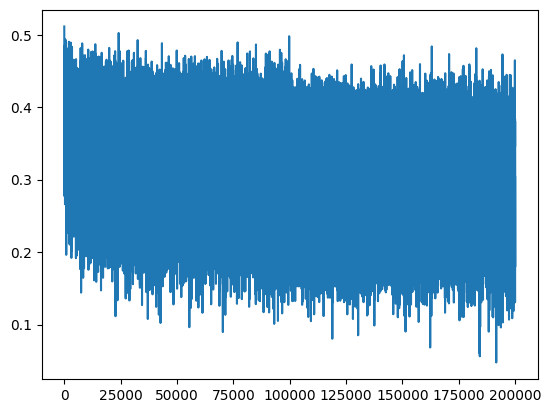

In [15]:
plt.plot(lossi)

In [ ]:
#Calibrating batch norm at end of training

with torch.no_grad():

    emb = C[X_train]
    embcat = emb.vie(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    #measuring the mean & std over entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad()

def split_loss(split):
    x,y = {
        'train': (X_train, y_train),
        'val': (X_dev, y_dev),
        'test': (X_test, y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(embcat @ W1 + b1)        #(N, hidden_size)
    logits = h @ W2 + b2                    #(N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9923299551010132
val 2.0504071712493896


In [12]:
#sampling from the model

g = torch.Generator().manual_seed(2147483647 + 10)
#block_size = 10

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]        #(1,block_size,d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

demine.
eviet.
dev.
b.
fl.
ter.
trik.
h.
k.
.
muh.
mcc.
x.
j.
ros.
brittin.
.
meir.
c.
rose.
